# **1. Setup, Data Loading and Mask Definition**

Import necessary libraries

In [6]:
import numpy as np
import pandas as pd
import time
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
import plotly.graph_objects as go
from scipy import ndimage
from skimage import segmentation
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

Mount Google Drive and Load Data

In [7]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Applied-Stat-Project/'
npy_file_path = f'{base_path}doses_scaled_ratio_2.npy'
csv_file_path = f'{base_path}data_reindexed.csv'
heart_mask_path = f'{base_path}resampled_heart_mask.npy'

print(f"Loading dose matrix from: {npy_file_path}")
doses_data = np.load(npy_file_path, mmap_mode='r')

print(f"Loading patient data from: {csv_file_path}")
df_patients = pd.read_csv(csv_file_path)

Mounted at /content/drive
Loading dose matrix from: /content/drive/MyDrive/Applied-Stat-Project/doses_scaled_ratio_2.npy
Loading patient data from: /content/drive/MyDrive/Applied-Stat-Project/data_reindexed.csv


Load and Validate the Heart ROI Mask

In [8]:
try:
    print(f"Loading heart mask from: {heart_mask_path}")
    heart_mask = np.load(heart_mask_path)
    assert heart_mask.shape == doses_data.shape[1:], \
        f"Dimension Mismatch! Mask shape ({heart_mask.shape}) must match dose grid shape ({doses_data.shape[1:]})."
    heart_mask = heart_mask.astype(bool)
    print("Heart mask loaded and validated successfully.")
except Exception as e:
    print(f"ERROR loading heart mask: {e}")
    heart_mask = None # Set to None if loading fails

print(f"\nDose matrix shape: {doses_data.shape}")
print(f"Patient DataFrame shape: {df_patients.shape}")
print("\nLoading complete.")

Loading heart mask from: /content/drive/MyDrive/Applied-Stat-Project/resampled_heart_mask.npy
Heart mask loaded and validated successfully.

Dose matrix shape: (310, 147, 168, 201)
Patient DataFrame shape: (310, 57)

Loading complete.


# **2. Data Splitting into 4 Groups**

In [9]:
# Get indices for Right vs. Left
right_indices = df_patients.index[df_patients['Site of Primary'].str.startswith('R', na=False)].tolist()
left_indices = df_patients.index[df_patients['Site of Primary'].str.startswith('L', na=False)].tolist()

# Get indices for Survival vs. Non-Survival within each side
right_survival_indices = df_patients.loc[right_indices][df_patients.loc[right_indices]['Overall Survival at 2 years'] == 'YES'].index.tolist()
right_non_survival_indices = df_patients.loc[right_indices][df_patients.loc[right_indices]['Overall Survival at 2 years'] == 'NO'].index.tolist()

left_survival_indices = df_patients.loc[left_indices][df_patients.loc[left_indices]['Overall Survival at 2 years'] == 'YES'].index.tolist()
left_non_survival_indices = df_patients.loc[left_indices][df_patients.loc[left_indices]['Overall Survival at 2 years'] == 'NO'].index.tolist()

print("Data splitting complete.")
print(f"Right side: {len(right_survival_indices)} survivors, {len(right_non_survival_indices)} non-survivors.")
print(f"Left side: {len(left_survival_indices)} survivors, {len(left_non_survival_indices)} non-survivors.")

Data splitting complete.
Right side: 100 survivors, 75 non-survivors.
Left side: 64 survivors, 50 non-survivors.


# **3. Creation of an Analysis Mask**

In [10]:
DOSE_THRESHOLD = 0.5

# --- Right Side Mask ---
mean_dose_map_right = np.mean(doses_data[right_indices], axis=0)
right_analysis_mask = mean_dose_map_right > DOSE_THRESHOLD
print(f"Right Side: Found {np.sum(right_analysis_mask)} relevant voxels in the general treatment area.")

# --- Left Side Mask ---
mean_dose_map_left = np.mean(doses_data[left_indices], axis=0)
left_analysis_mask = mean_dose_map_left > DOSE_THRESHOLD
print(f"Left Side: Found {np.sum(left_analysis_mask)} relevant voxels in the general treatment area.")

Right Side: Found 1633229 relevant voxels in the general treatment area.
Left Side: Found 1300274 relevant voxels in the general treatment area.


# **4. Guided Analysis and Hypothesis on the Heart ROI**

## **4.1. Is the Mean Heart Dose Different between Groups?**

Import required libraries

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

Mean heart dose per patient for each cohort

In [12]:
print("Calculating mean heart dose per patient for each cohort...")

mean_dose_survival_right = [np.mean(doses_data[i][heart_mask]) for i in right_survival_indices]
mean_dose_non_survival_right = [np.mean(doses_data[i][heart_mask]) for i in right_non_survival_indices]

mean_dose_survival_left = [np.mean(doses_data[i][heart_mask]) for i in left_survival_indices]
mean_dose_non_survival_left = [np.mean(doses_data[i][heart_mask]) for i in left_non_survival_indices]

combined_survival_indices = right_survival_indices + left_survival_indices
combined_non_survival_indices = right_non_survival_indices + left_non_survival_indices
combined_mean_dose_survival = [np.mean(doses_data[i][heart_mask]) for i in combined_survival_indices]
combined_mean_dose_non_survival = [np.mean(doses_data[i][heart_mask]) for i in combined_non_survival_indices]

print(f"Calculation complete. Mean dose values generated for {len(combined_mean_dose_survival)} total survivors and {len(combined_mean_dose_non_survival)} total non-survivors.")

Calculating mean heart dose per patient for each cohort...
Calculation complete. Mean dose values generated for 164 total survivors and 125 total non-survivors.


Perform and report T-tests for Right side and Left side

In [13]:
print("\n--- T-test Results for Mean Heart Dose ---")

# Right Side
t_stat, p_value = ttest_ind(mean_dose_survival_right, mean_dose_non_survival_right, equal_var=False)
print("\n--- Right Side Cohort ---")
print(f"Mean Dose (Survivors):     {np.mean(mean_dose_survival_right):.2f} Gy (std: {np.std(mean_dose_survival_right):.2f})")
print(f"Mean Dose (Non-Survivors): {np.mean(mean_dose_non_survival_right):.2f} Gy (std: {np.std(mean_dose_non_survival_right):.2f})")
print(f"P-value: {p_value:.4f}")

# Left Side
t_stat, p_value = ttest_ind(mean_dose_survival_left, mean_dose_non_survival_left, equal_var=False)
print("\n--- Left Side Cohort ---")
print(f"Mean Dose (Survivors):     {np.mean(mean_dose_survival_left):.2f} Gy (std: {np.std(mean_dose_survival_left):.2f})")
print(f"Mean Dose (Non-Survivors): {np.mean(mean_dose_non_survival_left):.2f} Gy (std: {np.std(mean_dose_non_survival_left):.2f})")
print(f"P-value: {p_value:.4f}")


--- T-test Results for Mean Heart Dose ---

--- Right Side Cohort ---
Mean Dose (Survivors):     3.69 Gy (std: 5.25)
Mean Dose (Non-Survivors): 5.16 Gy (std: 8.10)
P-value: 0.1740

--- Left Side Cohort ---
Mean Dose (Survivors):     2.13 Gy (std: 3.40)
Mean Dose (Non-Survivors): 2.56 Gy (std: 4.03)
P-value: 0.5501


Combined Cohort (most powerful)


--- Combined (Right+Left) Cohort ---
Mean Dose (Survivors):     3.08 Gy (std: 4.68)
Mean Dose (Non-Survivors): 4.12 Gy (std: 6.89)
P-value: 0.1487
CONCLUSION: No statistically significant difference was found for mean heart dose.

Visualizing the distribution for the combined cohort...


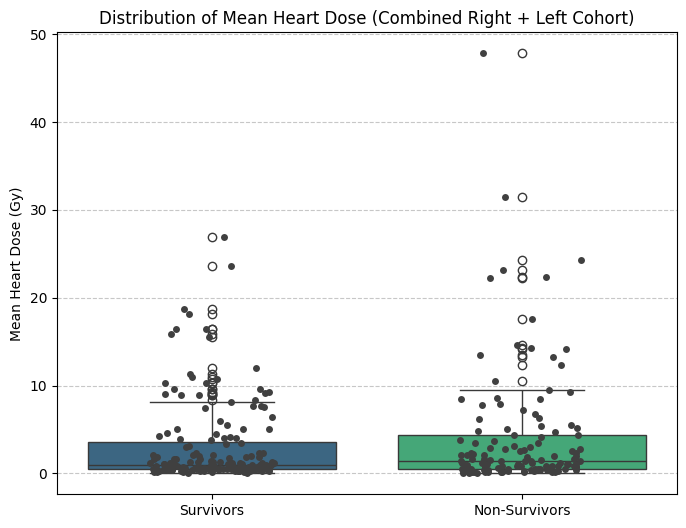

In [14]:
t_stat_comb, p_value_comb = ttest_ind(combined_mean_dose_survival, combined_mean_dose_non_survival, equal_var=False)
print("\n--- Combined (Right+Left) Cohort ---")
print(f"Mean Dose (Survivors):     {np.mean(combined_mean_dose_survival):.2f} Gy (std: {np.std(combined_mean_dose_survival):.2f})")
print(f"Mean Dose (Non-Survivors): {np.mean(combined_mean_dose_non_survival):.2f} Gy (std: {np.std(combined_mean_dose_non_survival):.2f})")
print(f"P-value: {p_value_comb:.4f}")
if p_value_comb < 0.05:
    print("CONCLUSION: A statistically significant difference was found in the combined cohort.")
else:
    print("CONCLUSION: No statistically significant difference was found for mean heart dose.")

# --- Visualize the most powerful result (Combined Cohort) ---
print("\nVisualizing the distribution for the combined cohort...")
plt.figure(figsize=(8, 6))
sns.boxplot(data=[combined_mean_dose_survival, combined_mean_dose_non_survival], palette="viridis")
sns.stripplot(data=[combined_mean_dose_survival, combined_mean_dose_non_survival], color=".25", jitter=0.2)
plt.xticks([0, 1], ['Survivors', 'Non-Survivors'])
plt.ylabel("Mean Heart Dose (Gy)")
plt.title("Distribution of Mean Heart Dose (Combined Right + Left Cohort)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **4.2. Is Heart V20 Different between Groups?**

Define DVH parameters (can be modified to calculate V5, V10, V30, ...)

In [15]:
dose_threshold = 20.0  # Gy

Calculation for the combined cohort

In [16]:
print(f"Calculating V{int(dose_threshold)} for each patient in the combined cohort...")
total_voxels_in_heart = np.sum(heart_mask)

# Using list comprehensions with indices to stay memory-efficient
voxels_above_threshold_survival = [np.sum(doses_data[i][heart_mask] >= dose_threshold) for i in combined_survival_indices]
voxels_above_threshold_non_survival = [np.sum(doses_data[i][heart_mask] >= dose_threshold) for i in combined_non_survival_indices]

# Convert voxel count to percentage volume
v20_survival = (np.array(voxels_above_threshold_survival) / total_voxels_in_heart) * 100
v20_non_survival = (np.array(voxels_above_threshold_non_survival) / total_voxels_in_heart) * 100

Calculating V20 for each patient in the combined cohort...


Perform and report T-test on V20


--- T-test Results for Heart V20 (Combined Cohort) ---
Mean Heart V20 (Survivors):   3.84% (std: 8.82)
Mean Heart V20 (Non-Survivors): 5.66% (std: 12.70)
P-value: 0.1752
CONCLUSION: No statistically significant difference was found for this DVH parameter.

Visualizing the V20 distribution...


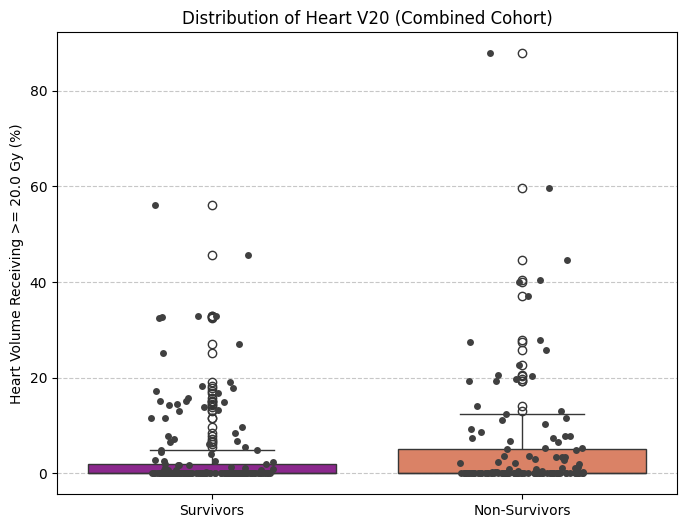

In [17]:
t_stat_v20, p_value_v20 = ttest_ind(v20_survival, v20_non_survival, equal_var=False)
print(f"\n--- T-test Results for Heart V{int(dose_threshold)} (Combined Cohort) ---")
print(f"Mean Heart V{int(dose_threshold)} (Survivors):   {np.mean(v20_survival):.2f}% (std: {np.std(v20_survival):.2f})")
print(f"Mean Heart V{int(dose_threshold)} (Non-Survivors): {np.mean(v20_non_survival):.2f}% (std: {np.std(v20_non_survival):.2f})")
print(f"P-value: {p_value_v20:.4f}")
if p_value_v20 < 0.05:
    print("CONCLUSION: A statistically significant difference was found for this DVH parameter.")
else:
    print("CONCLUSION: No statistically significant difference was found for this DVH parameter.")

# --- Visualize V20 distribution ---
print("\nVisualizing the V20 distribution...")
plt.figure(figsize=(8, 6))
sns.boxplot(data=[v20_survival, v20_non_survival], palette="plasma")
sns.stripplot(data=[v20_survival, v20_non_survival], color=".25", jitter=0.2)
plt.xticks([0, 1], ['Survivors', 'Non-Survivors'])
plt.ylabel(f"Heart Volume Receiving >= {dose_threshold} Gy (%)")
plt.title(f"Distribution of Heart V{int(dose_threshold)} (Combined Cohort)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **5. Statistical Analysis**

## **5.1. Voxel-wise ROI p-map**

Define parameters

In [18]:
N_PERMUTATIONS_ROI = 1000  # Increase for more precision, e.g., to 5000

# Get grid dimensions for plotting
nx, ny, nz = doses_data.shape[1:]
X, Y, Z = np.mgrid[:nx, :ny, :nz]

Function for voxel-wise permutation testing within a mask

In [ ]:
def run_permutation_test_in_mask(survival_indices, non_survival_indices, roi_mask, analysis_mask, n_permutations, desc=""):
    final_test_mask = roi_mask & analysis_mask
    coords_to_test = np.argwhere(final_test_mask)
    if len(coords_to_test) == 0:
        print(f"WARNING for {desc}: The provided ROI mask has no overlap with the analysis mask. Skipping.")
        return None, None
    print(f"\nRunning {n_permutations} permutations on {len(coords_to_test)} voxels for {desc}...")

    all_indices = survival_indices + non_survival_indices
    # Memory-efficient way to get the dose subset
    doses_subset = np.array([doses_data[i][tuple(coords_to_test.T)] for i in all_indices])

    n_survival = len(survival_indices)
    labels = np.array([1] * n_survival + [0] * (len(all_indices) - n_survival))
    mean_diff_actual = np.mean(doses_subset[labels==1], axis=0) - np.mean(doses_subset[labels==0], axis=0)

    p_value_counts = np.zeros(len(coords_to_test), dtype=int)
    for _ in tqdm(range(n_permutations), desc=f"Permutations ({desc})"):
        permuted_labels = np.random.permutation(labels)
        mean_diff_permuted = np.mean(doses_subset[permuted_labels==1], axis=0) - np.mean(doses_subset[permuted_labels==0], axis=0)
        p_value_counts += (np.abs(mean_diff_permuted) > np.abs(mean_diff_actual))

    p_values_flat = (p_value_counts + 1) / (n_permutations + 1)
    p_map = np.ones((nx, ny, nz))
    p_map[coords_to_test[:, 0], coords_to_test[:, 1], coords_to_test[:, 2]] = p_values_flat
    return p_map, final_test_mask

Run for Right & Left Side Heart

In [ ]:
if heart_mask is not None:
    p_map_heart_right, test_mask_heart_right = run_permutation_test_in_mask(
        right_survival_indices, right_non_survival_indices, heart_mask, right_analysis_mask, N_PERMUTATIONS_ROI, "Heart ROI (Right Side)"
    )
    p_map_heart_left, test_mask_heart_left = run_permutation_test_in_mask(
        left_survival_indices, left_non_survival_indices, heart_mask, left_analysis_mask, N_PERMUTATIONS_ROI, "Heart ROI (Left Side)"
    )
else:
    print("Skipping Heart ROI P-Map generation because the mask was not loaded.")
    p_map_heart_right, p_map_heart_left = None, None


Running 1000 permutations on 32898 voxels for Heart ROI (Right Side)...


Permutations (Heart ROI (Right Side)):   0%|          | 0/1000 [00:00<?, ?it/s]


Running 1000 permutations on 28467 voxels for Heart ROI (Left Side)...


Permutations (Heart ROI (Left Side)):   0%|          | 0/1000 [00:00<?, ?it/s]

Function for p-map plotting

In [ ]:
def plot_pmap(p_map, test_mask, title):
    if p_map is None: return
    log_p_map = -np.log10(p_map)
    log_p_map_masked = log_p_map * test_mask

    min_p_val = np.min(p_map[test_mask])
    print(f"Minimum p-value found for '{title}': {min_p_val:.4f}")

    isomin = -np.log10(0.2) # Set a lower threshold for visualization, e.g., p=0.2
    isomax = np.max(log_p_map_masked) if np.sum(log_p_map_masked > 0) > 0 else isomin + 1.0

    fig = go.Figure(data=go.Volume(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=log_p_map_masked.flatten(),
        isomin=isomin, isomax=isomax, opacity=0.3, surface_count=15,
        colorscale="Inferno", colorbar=dict(title='-log10(p-value)')
    ))
    fig.update_layout(title=title)
    fig.show()

Visualization of Heart ROI P-Maps

In [ ]:
print("\n--- Visualizing Heart ROI P-Maps ---")
plot_pmap(p_map_heart_right, test_mask_heart_right, "P-Map 1: Voxel-wise Analysis within Heart ROI (Right Side)")
plot_pmap(p_map_heart_left, test_mask_heart_left, "P-Map 2: Voxel-wise Analysis within Heart ROI (Left Side)")

Output hidden; open in https://colab.research.google.com to view.

## **5.2. Supervoxel p-map**

In [26]:
ALPHA_LEVEL = 0.5 # can be modified to have a different threshold
N_PERMUTATIONS = 10000 # Increase for more precision, e.g., to 5000, 10000

### **5.2.1. Full Image**

Function for the full exploratory supervoxel analysis

In [4]:
def run_supervoxel_analysis(survival_indices, non_survival_indices, mean_dose_map, analysis_mask, n_permutations, desc=""):
    print(f"\n--- Starting Supervoxel Analysis for {desc} ---")

    # 1. Segmentation
    print("Step 1: Performing SLIC segmentation...")
    supervoxel_labels = segmentation.slic(mean_dose_map, n_segments=5000, compactness=10, start_label=1, channel_axis=None)

    # 2. Aggregation
    print("Step 2: Aggregating doses per supervoxel...")
    def aggregate_doses(indices, labels, agg_desc):
        unique_labels = np.unique(labels)[1:]
        # Memory-efficient aggregation
        doses_agg = np.array([ndimage.mean(doses_data[i], labels=labels, index=unique_labels) for i in tqdm(indices, desc=f'Aggregating ({agg_desc})')])
        return doses_agg, unique_labels
    survival_sv_doses, sv_labels = aggregate_doses(survival_indices, supervoxel_labels, "Survivors")
    non_survival_sv_doses, _ = aggregate_doses(non_survival_indices, supervoxel_labels, "Non-Survivors")

    # 3. Permutation Test on Supervoxels
    print("Step 3: Running permutation test on supervoxels...")
    all_sv_doses = np.concatenate([survival_sv_doses, non_survival_sv_doses], axis=0)
    labels = np.array([1] * len(survival_indices) + [0] * len(non_survival_indices))
    actual_difference_sv = np.mean(survival_sv_doses, axis=0) - np.mean(non_survival_sv_doses, axis=0)

    max_diffs_permuted = np.zeros(n_permutations)
    for i in tqdm(range(n_permutations), desc=f"Supervoxel Permutations ({desc})"):
        perm_labels = np.random.permutation(labels)
        perm_diff = np.mean(all_sv_doses[perm_labels==1], axis=0) - np.mean(all_sv_doses[perm_labels==0], axis=0)
        max_diffs_permuted[i] = np.max(np.abs(perm_diff))

    # 4. Identify significant supervoxels with correction
    print("Step 4: Identifying significant supervoxels with FWE correction...")
    diff_threshold_corrected = np.percentile(max_diffs_permuted, 100 - (ALPHA_LEVEL * 100))
    significant_sv_mask = np.abs(actual_difference_sv) > diff_threshold_corrected
    significant_sv_labels = sv_labels[significant_sv_mask]

    print(f"RESULT: Found {len(significant_sv_labels)} significant supervoxels for {desc} (Corrected Difference Threshold: {diff_threshold_corrected:.4f})")

    # 5. Create the final map for visualization
    if len(significant_sv_labels) > 0:
        voxel_wise_difference = np.mean(doses_data[survival_indices], axis=0) - np.mean(doses_data[non_survival_indices], axis=0)
        significant_voxel_map = np.isin(supervoxel_labels, significant_sv_labels) & analysis_mask
        difference_map_masked = voxel_wise_difference * significant_voxel_map
        return difference_map_masked, significant_voxel_map
    else:
        return None, None

Run for Right Side and Left Side

In [27]:
diff_map_sv_right, sig_mask_sv_right = run_supervoxel_analysis(
    right_survival_indices, right_non_survival_indices, mean_dose_map_right, right_analysis_mask, N_PERMUTATIONS, "Right Side"
)


--- Starting Supervoxel Analysis for Right Side ---
Step 1: Performing SLIC segmentation...
Step 2: Aggregating doses per supervoxel...


Aggregating (Survivors):   0%|          | 0/100 [00:00<?, ?it/s]

Aggregating (Non-Survivors):   0%|          | 0/75 [00:00<?, ?it/s]

Step 3: Running permutation test on supervoxels...


Supervoxel Permutations (Right Side):   0%|          | 0/10000 [00:00<?, ?it/s]

Step 4: Identifying significant supervoxels with FWE correction...
RESULT: Found 1 significant supervoxels for Right Side (Corrected Difference Threshold: 6.0141)


In [29]:
diff_map_sv_left, sig_mask_sv_left = run_supervoxel_analysis(
    left_survival_indices, left_non_survival_indices, mean_dose_map_left, left_analysis_mask, N_PERMUTATIONS, "Left Side"
)


--- Starting Supervoxel Analysis for Left Side ---
Step 1: Performing SLIC segmentation...
Step 2: Aggregating doses per supervoxel...


Aggregating (Survivors):   0%|          | 0/64 [00:00<?, ?it/s]

Aggregating (Non-Survivors):   0%|          | 0/50 [00:00<?, ?it/s]

Step 3: Running permutation test on supervoxels...


Supervoxel Permutations (Left Side):   0%|          | 0/10000 [00:00<?, ?it/s]

Step 4: Identifying significant supervoxels with FWE correction...
RESULT: Found 15 significant supervoxels for Left Side (Corrected Difference Threshold: 7.1742)


Function for visualization of supervoxel difference maps

In [22]:
def plot_diffmap(diff_map, sig_mask, title):
    if diff_map is None:
        print(f"\nCannot generate plot for '{title}': no significant regions were found.")
        return
    min_val, max_val = np.min(diff_map[sig_mask]), np.max(diff_map[sig_mask])
    fig = go.Figure(data=go.Volume(
        x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
        value=diff_map.flatten(),
        isomin=min_val, isomax=max_val, opacity=0.3, surface_count=15,
        colorscale="RdBu_r", colorbar=dict(title='Dose Difference (Gy)')
    ))
    fig.update_layout(title=title)
    fig.show()

Visualization of Supervoxel Difference p-maps

In [28]:
plot_diffmap(diff_map_sv_right, sig_mask_sv_right, "P-Map 3: Significant Dose Differences from Supervoxel Analysis (Right Side)")

Output hidden; open in https://colab.research.google.com to view.

In [30]:
plot_diffmap(diff_map_sv_left, sig_mask_sv_left, "P-Map 4: Significant Dose Differences from Supervoxel Analysis (Left Side)")

Output hidden; open in https://colab.research.google.com to view.

### **5.2.2. ROI**

Function for ROI supervoxel explorative analysis

In [1]:
def run_supervoxel_analysis_on_roi(survival_indices, non_survival_indices, supervoxel_labels, roi_mask, analysis_mask, n_permutations, desc=""):
    print(f"\n--- Starting Focused Supervoxel Analysis for {desc} ---")

    # --- Step 1: Identify supervoxels that are inside the specified ROI ---
    print("Step 1: Identifying supervoxels within the Heart ROI...")

    # The ROI for this analysis is the intersection of the heart mask and the general analysis mask
    final_roi_mask = roi_mask & analysis_mask

    # Find the unique labels of supervoxels that fall within our final ROI mask
    relevant_sv_labels = np.unique(supervoxel_labels[final_roi_mask])
    # Ensure we don't include the background label if it's present
    relevant_sv_labels = relevant_sv_labels[relevant_sv_labels != 0]

    if len(relevant_sv_labels) == 0:
        print(f"RESULT: No supervoxels found within the specified ROI for {desc}. Cannot proceed.")
        return None, None

    print(f"Found {len(relevant_sv_labels)} supervoxels to test within the ROI.")

    # --- Step 2: Aggregate doses ONLY for the relevant supervoxels ---
    print("Step 2: Aggregating doses for the relevant supervoxels...")
    def aggregate_doses_roi(indices, labels, target_labels, agg_desc):
        # Memory-efficient aggregation for the target labels
        doses_agg = np.array([ndimage.mean(doses_data[i], labels=labels, index=target_labels) for i in tqdm(indices, desc=f'Aggregating ({agg_desc})')])
        return doses_agg

    survival_sv_doses_roi = aggregate_doses_roi(survival_indices, supervoxel_labels, relevant_sv_labels, "Survivors")
    non_survival_sv_doses_roi = aggregate_doses_roi(non_survival_indices, supervoxel_labels, relevant_sv_labels, "Non-Survivors")

    # --- Step 3: Permutation Test on the filtered set of supervoxels ---
    print("Step 3: Running permutation test on the ROI-specific supervoxels...")
    all_sv_doses_roi = np.concatenate([survival_sv_doses_roi, non_survival_sv_doses_roi], axis=0)
    labels = np.array([1] * len(survival_indices) + [0] * len(non_survival_indices))
    actual_difference_sv_roi = np.mean(survival_sv_doses_roi, axis=0) - np.mean(non_survival_sv_doses_roi, axis=0)

    # The multiple comparison correction is now against a smaller number of tests, increasing power
    max_diffs_permuted = np.zeros(n_permutations)
    for i in tqdm(range(n_permutations), desc=f"Supervoxel Permutations ({desc})"):
        perm_labels = np.random.permutation(labels)
        perm_diff = np.mean(all_sv_doses_roi[perm_labels==1], axis=0) - np.mean(all_sv_doses_roi[perm_labels==0], axis=0)
        max_diffs_permuted[i] = np.max(np.abs(perm_diff))

    # --- Step 4: Identify significant supervoxels with correction ---
    print("Step 4: Identifying significant supervoxels with FWE correction...")
    diff_threshold_corrected = np.percentile(max_diffs_permuted, 100 - (ALPHA_LEVEL * 100))
    significant_sv_mask = np.abs(actual_difference_sv_roi) > diff_threshold_corrected
    significant_sv_labels = relevant_sv_labels[significant_sv_mask]

    print(f"RESULT: Found {len(significant_sv_labels)} significant supervoxels within the ROI for {desc} (Threshold: {diff_threshold_corrected:.4f})")

    # --- Step 5: Create the final map for visualization ---
    if len(significant_sv_labels) > 0:
        voxel_wise_difference = np.mean(doses_data[survival_indices], axis=0) - np.mean(doses_data[non_survival_indices], axis=0)
        significant_voxel_map = np.isin(supervoxel_labels, significant_sv_labels) # No need to mask again, it's implied
        difference_map_masked = voxel_wise_difference * significant_voxel_map
        return difference_map_masked, significant_voxel_map
    else:
        return None, None

Results and visualization after a prerequisite check

In [31]:
if 'supervoxel_labels_right' not in locals() or 'supervoxel_labels_left' not in locals():
    print("\nERROR: Supervoxel labels from Section 5.2.1 not found. Please run Section 5.2.1 before this one.")
elif heart_mask is None:
    print("\nERROR: Heart mask not found. Please ensure it was loaded correctly in Section 1.")
else:
    # --- Run for Right Side Heart ROI ---
    # We re-use the supervoxel_labels_right calculated in the full-image analysis
    diff_map_sv_heart_right, sig_mask_sv_heart_right = run_supervoxel_analysis_on_roi(
        right_survival_indices, right_non_survival_indices, supervoxel_labels_right, heart_mask, right_analysis_mask, N_PERMUTATIONS_ROI, "Heart ROI (Right Side)"
    )

    # --- Run for Left Side Heart ROI ---
    # We re-use the supervoxel_labels_left calculated in the full-image analysis
    diff_map_sv_heart_left, sig_mask_sv_heart_left = run_supervoxel_analysis_on_roi(
        left_survival_indices, left_non_survival_indices, supervoxel_labels_left, heart_mask, left_analysis_mask, N_PERMUTATIONS_ROI, "Heart ROI (Left Side)"
    )

    # --- Visualization ---
    # The plot_diffmap function was defined in the previous section, we can reuse it here.
    print("\n--- Visualizing Focused Supervoxel Analysis Results ---")
    plot_diffmap(diff_map_sv_heart_right, sig_mask_sv_heart_right, "Focused Supervoxel Analysis within Heart (Right Side)")
    plot_diffmap(diff_map_sv_heart_left, sig_mask_sv_heart_left, "Focused Supervoxel Analysis within Heart (Left Side)")


ERROR: Supervoxel labels from Section 5.2.1 not found. Please run Section 5.2.1 before this one.
